In [1]:
!python -V

Python 3.10.9


In [48]:
import pandas as pd

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

In [66]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [109]:
import pickle

### Q1. Downloading the data

In [25]:
df = pd.read_parquet("./data/yellow_tripdata_2022-01.parquet")

In [26]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.50,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.00,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.50,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.00,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.50,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2463926,2,2022-01-31 23:36:53,2022-01-31 23:42:51,NaN,1.32,NaN,None,90,170,0,8.00,0.0,0.5,2.39,0.0,0.3,13.69,NaN,NaN
2463927,2,2022-01-31 23:44:22,2022-01-31 23:55:01,NaN,4.19,NaN,None,107,75,0,16.80,0.0,0.5,4.35,0.0,0.3,24.45,NaN,NaN
2463928,2,2022-01-31 23:39:00,2022-01-31 23:50:00,NaN,2.10,NaN,None,113,246,0,11.22,0.0,0.5,2.00,0.0,0.3,16.52,NaN,NaN
2463929,2,2022-01-31 23:36:42,2022-01-31 23:48:45,NaN,2.92,NaN,None,148,164,0,12.40,0.0,0.5,0.00,0.0,0.3,15.70,NaN,NaN


In [27]:
# calculate number of columns
len(df.columns)

19

### Q2. Computing duration

In [30]:
# calculate duration
df["duration"] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime 

In [31]:
df["duration"] = df.duration.apply(lambda td: td.total_seconds() / 60)

In [32]:
# determine standard deviation of trip duration in January
df.duration.describe()

count    2.463931e+06
mean     1.421220e+01
std      4.644531e+01
min     -3.442400e+03
25%      6.316667e+00
50%      1.018333e+01
75%      1.616667e+01
max      8.513183e+03
Name: duration, dtype: float64

### Q3. Dropping outliers

In [39]:
# calculate fraction of records left after dropping outliers
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9827547930522406

In [73]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

### Q4. One-hot encoding

In [74]:
categorical = ["PULocationID", "DOLocationID"]

In [75]:
df[categorical] = df[categorical].astype(str)

/tmp/ipykernel_2636/1767203464.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical].astype(str)


In [76]:
train_dicts = df[categorical].to_dict(orient="records")

In [77]:
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [78]:
# calculate dimensionality after OHE
X_train

<2421440x515 sparse matrix of type '<class 'numpy.float64'>'
	with 4842880 stored elements in Compressed Sparse Row format>

### Q5. Training a model

In [79]:
target = "duration"
y_train = df[target].values

In [80]:
y_train

array([17.81666667,  8.4       ,  8.96666667, ..., 11.        ,
       12.05      , 27.        ])

In [81]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [82]:
y_pred = lr.predict(X_train)

/tmp/ipykernel_2636/1219225857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/tmp/ipykernel_2636/1219225857.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label="actual")


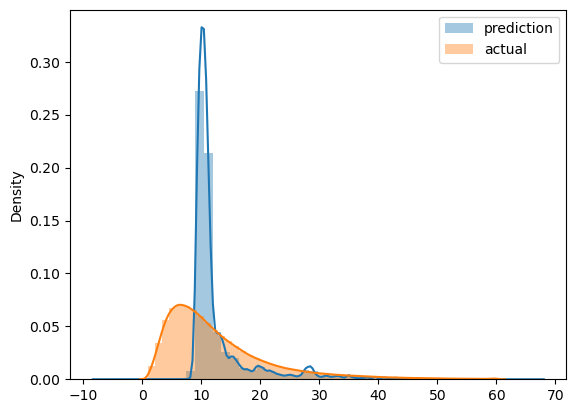

In [83]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [84]:
mean_squared_error(y_train, y_pred, squared=False)

6.986190836477672

### Q6. Evaluating the model

In [97]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)
        df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [98]:
df_train = read_dataframe('./data/yellow_tripdata_2022-01.parquet')
df_val = read_dataframe('./data/yellow_tripdata_2022-02.parquet')

In [99]:
len(df_train), len(df_val)

(2421440, 2918187)

In [111]:
categorical

['PULocationID', 'DOLocationID']

In [104]:
categorical = ["PULocationID", "DOLocationID"]

dv = DictVectorizer()

train_dicts = df_train[categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [105]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [106]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.78640879016696

In [110]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)